In [1]:
import os
from collections import Counter

import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

from tensorflow import keras, config
# Configure GPU memory to run alongside other training tasks
gpus = config.experimental.list_physical_devices('GPU')
config.experimental.set_virtual_device_configuration(gpus[0], [config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 8)]) # 1024MB * 8 = 8GB
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Hide tf warnings
from keras.models import load_model

from cascid.datasets.pad_ufes.database import get_images_with_no_metadata
from cascid.datasets.isic.database import get_train_test_images_raw, get_train_test_images_hairless
from cascid.datasets.pad_ufes import images as pad_ufes_images
from cascid.configs.config import DATA_DIR

2022-11-09 08:20:40.494396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 08:20:40.732855: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-09 08:20:41.536709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-09 08:20:41.536793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## PAD-UFES

In [8]:
pad_ufes_vals_raw = dict()
pad_ufes_vals_hairless = dict()
# df
df = get_images_with_no_metadata()
categories = [np.array(sorted(df['is_cancer'].value_counts().index.to_list()), dtype='object')]
ohe = OneHotEncoder(sparse=False, categories=categories, handle_unknown="ignore")
ohe.fit(df[['is_cancer']])
# x
pad_ufes_vals_raw['x_test'] = df['img_id'].apply(lambda imname: pad_ufes_images.get_raw_image(imname, (256,256))).to_numpy()
pad_ufes_vals_raw['x_test'] = np.array([i for i in pad_ufes_vals_raw['x_test']])
# y
pad_ufes_vals_raw['y_test'] = df['is_cancer'].to_list()

# x
pad_ufes_vals_hairless['x_test'] = df['img_id'].apply(lambda imname: pad_ufes_images.get_hairless_image(imname, (256,256))).to_numpy()
pad_ufes_vals_hairless['x_test'] = np.array([i for i in pad_ufes_vals_hairless['x_test']])
# y
pad_ufes_vals_hairless['y_test'] = df['is_cancer'].to_list()

## ISIC

In [3]:
isic_vals_raw = dict()
# df
_, isic_vals_raw['x_test'], _, isic_vals_raw['y_test'] = get_train_test_images_raw()
isic_vals_raw['y_test'] = list(map(lambda x: "Cancer" if x in ["MEL", "SCC", "BCC"] else "Not", isic_vals_raw['y_test'].flatten()))

isic_vals_hairless = dict()
# df
_, isic_vals_hairless['x_test'], _, isic_vals_hairless['y_test'] = get_train_test_images_hairless()
isic_vals_hairless['y_test'] = list(map(lambda x: "Cancer" if x in ["MEL", "SCC", "BCC"] else "Not", isic_vals_hairless['y_test'].flatten()))

## Evaluation

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues, save_to_file = False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true' if normalize else None)
    
    #print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.3f' if normalize else 'd'
    thresh = cm.mean()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig('Assets/files/' + title + '.pdf')
    return ax

In [13]:
def evaluate_model_performance(model: keras.models.Sequential, title:str, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred = ohe.inverse_transform(y_pred).flatten()
    acc = accuracy_score(y_test, y_pred)
    if acc < 0.5:
        y_pred_fixed = ["Not" if x == "Cancer" else "Cancer" for x in y_pred]
        acc = 1-acc
    else:
        y_pred_fixed = y_pred
    print("Model accuracy for {}: {:.3f}%".format(title, 100*acc))
    plot_confusion_matrix(
        y_true=y_test,
        y_pred=y_pred_fixed,
        classes=ohe.categories_[0].tolist(),
        normalize=True,
        title=title
    );

#### ISIC MODELS ON PAD-UFES

Class ratio is 53.405%
29/29 [==============================] - 1s 23ms/step
Model accuracy for final_isic_resnet34_aug_hairless: 57.622%
29/29 [==============================] - 1s 23ms/step
Model accuracy for final_isic_resnet34_noaug_hairless: 54.270%
29/29 [==============================] - 1s 23ms/step
Model accuracy for final_isic_resnet34_noaug_raw: 51.784%
29/29 [==============================] - 1s 24ms/step
Model accuracy for final_isic_resnet34_aug_raw: 59.784%
29/29 [==============================] - 1s 16ms/step
Model accuracy for final_isic_resnet18_aug_hairless: 59.784%
29/29 [==============================] - 1s 16ms/step
Model accuracy for final_isic_resnet18_noaug_hairless: 56.216%
29/29 [==============================] - 1s 16ms/step
Model accuracy for final_isic_resnet18_noaug_raw: 52.541%
29/29 [==============================] - 1s 15ms/step
Model accuracy for final_isic_resnet18_aug_raw: 55.351%


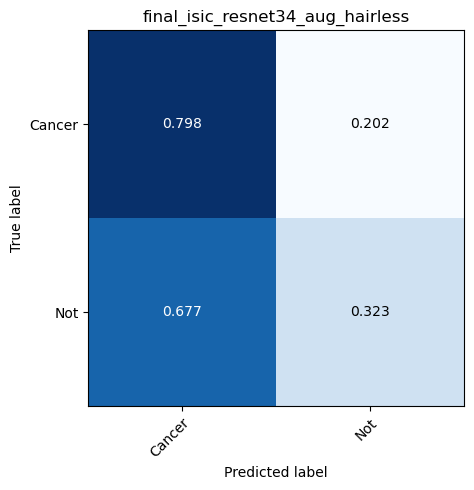

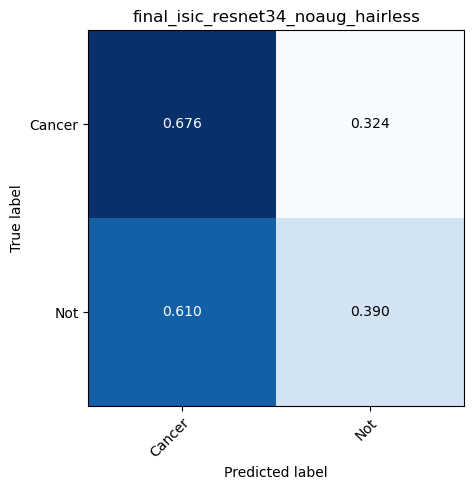

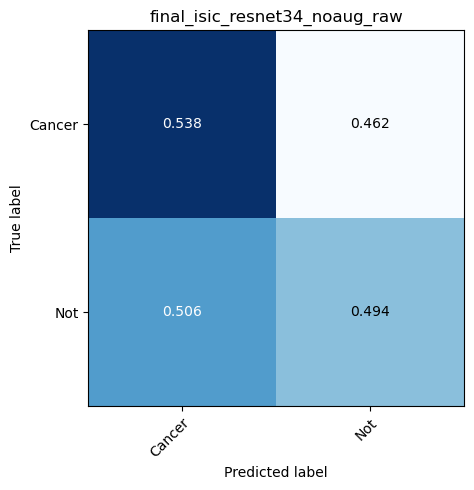

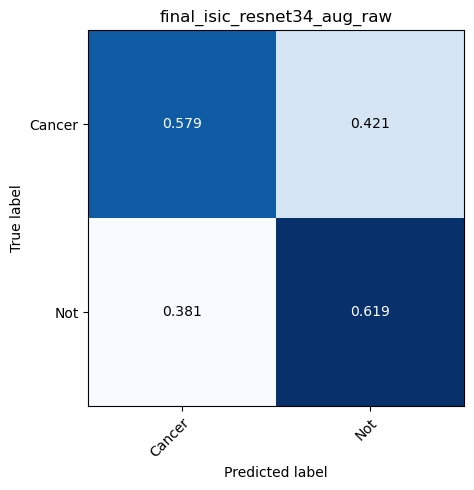

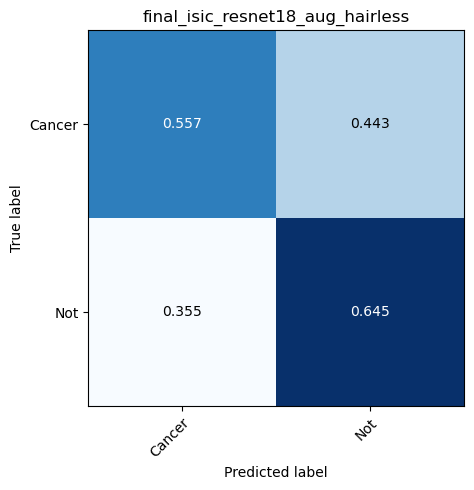

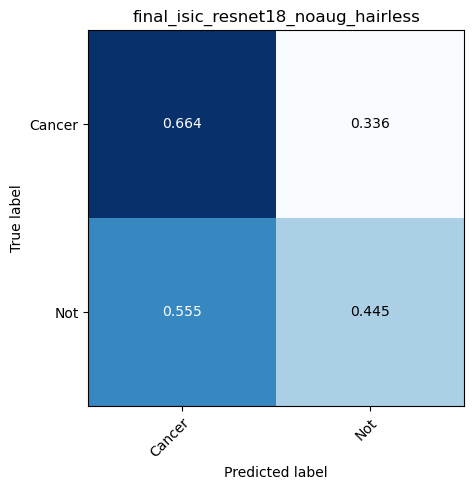

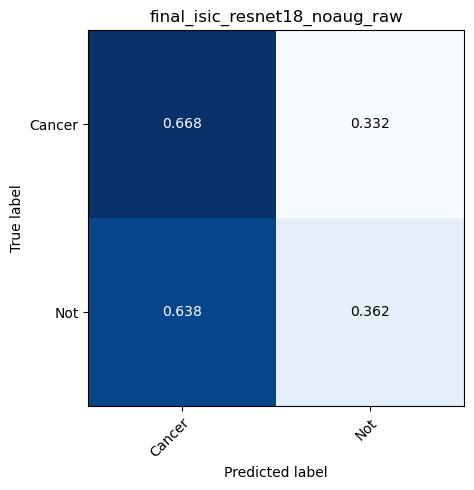

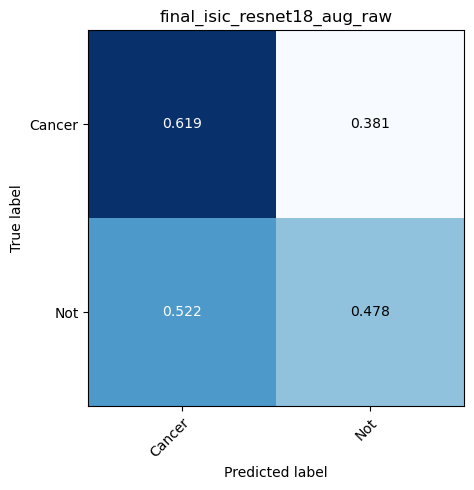

In [11]:
exp_dir = DATA_DIR / 'experiments'
cnt = Counter(df['is_cancer'].to_list())
ratio = cnt['Cancer'] / (cnt["Cancer"] + cnt["Not"])
ratio = 1-ratio if ratio < 0.5 else ratio
print("Class ratio is {:.3f}%".format(100*ratio))
for mod in ['resnet34', 'resnet18']:
    for style in ['aug_hairless', 'noaug_hairless']:
        title = "final_isic_{}_{}".format(mod , style)
        model_path = exp_dir / 'final_isic' / mod / style
        model = load_model(model_path)
        evaluate_model_performance(model, title, **pad_ufes_vals_hairless)
    for style in ['noaug_raw', 'aug_raw']:
        title = "final_isic_{}_{}".format(mod , style)
        model_path = exp_dir / 'final_isic' / mod / style
        model = load_model(model_path)
        evaluate_model_performance(model, title, **pad_ufes_vals_raw)


#### PAD-UFES MODELS ON ISIC

Class ratio is 55.694%
76/76 [==============================] - 2s 24ms/step
Model accuracy for final_pad_ufes_resnet34_aug_hairless: 56.563%
76/76 [==============================] - 2s 23ms/step
Model accuracy for final_pad_ufes_resnet34_noaug_hairless: 60.497%
76/76 [==============================] - 2s 24ms/step
Model accuracy for final_pad_ufes_resnet34_noaug_raw;: 56.646%
76/76 [==============================] - 2s 24ms/step
Model accuracy for final_pad_ufes_resnet34_aug_raw;: 56.522%
76/76 [==============================] - 1s 15ms/step
Model accuracy for final_pad_ufes_resnet18_aug_hairless: 52.588%
76/76 [==============================] - 1s 16ms/step
Model accuracy for final_pad_ufes_resnet18_noaug_hairless: 55.404%
76/76 [==============================] - 2s 17ms/step
Model accuracy for final_pad_ufes_resnet18_noaug_raw;: 54.824%
76/76 [==============================] - 1s 16ms/step
Model accuracy for final_pad_ufes_resnet18_aug_raw;: 52.588%


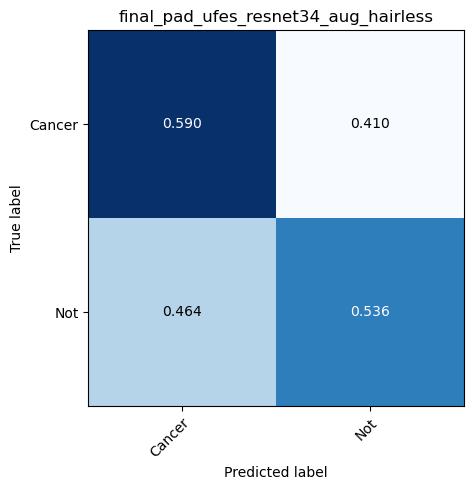

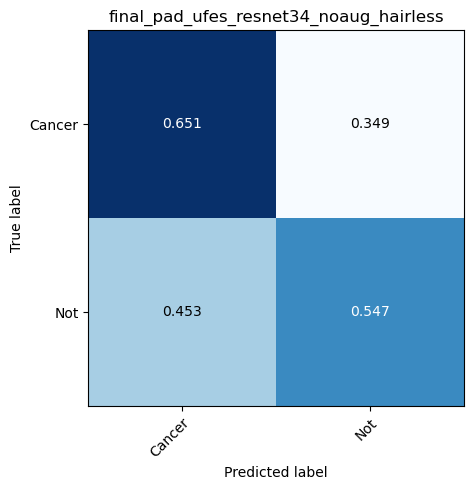

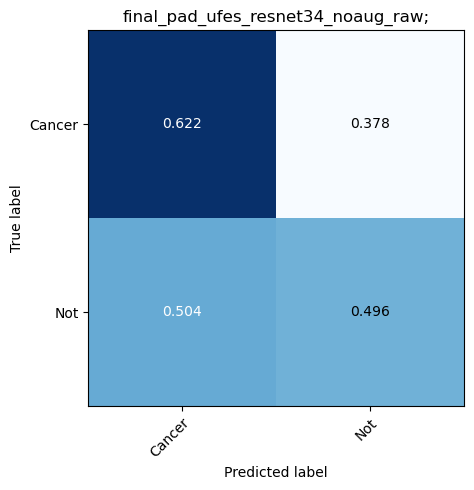

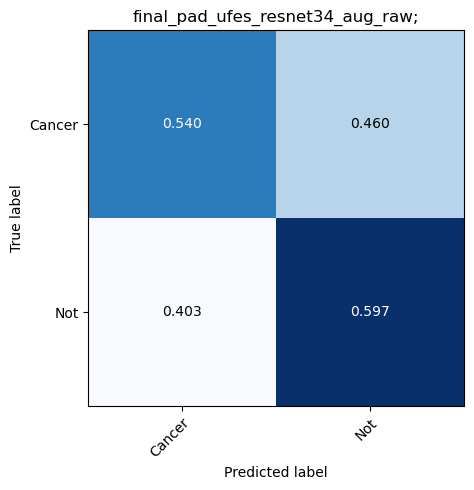

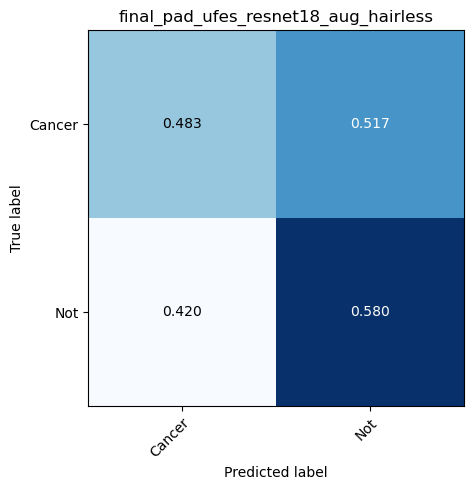

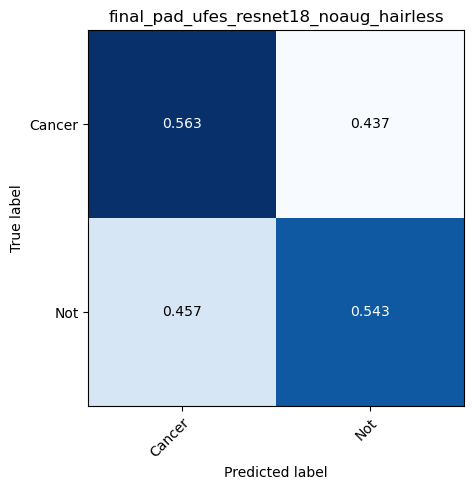

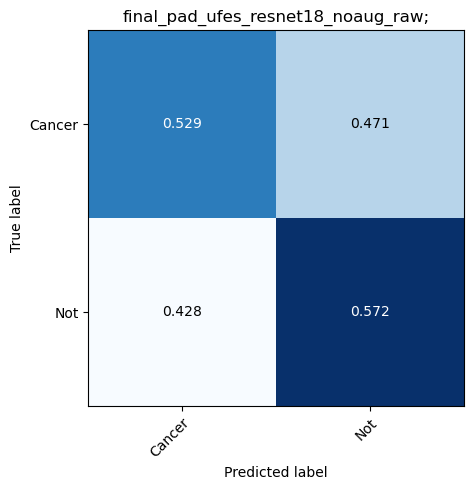

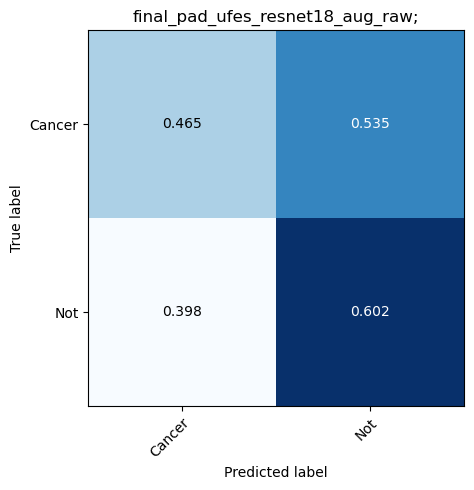

In [14]:
exp_dir = DATA_DIR / 'experiments'
cnt = Counter(isic_vals_raw['y_test'])
ratio = cnt['Cancer'] / (cnt["Cancer"] + cnt["Not"])
ratio = 1-ratio if ratio < 0.5 else ratio
print("Class ratio is {:.3f}%".format(100*ratio))
for mod in ['resnet34', 'resnet18']:
    for style in ['aug_hairless', 'noaug_hairless']:
        title = "final_pad_ufes_{}_{}".format(mod , style)
        model_path = exp_dir / 'final_pad_ufes' / mod / style
        model = load_model(model_path)
        evaluate_model_performance(model, title, **isic_vals_hairless)
    for style in ['noaug_raw', 'aug_raw']:
        title = "final_pad_ufes_{}_{};".format(mod , style)
        model_path = exp_dir / 'final_pad_ufes' / mod / style
        model = load_model(model_path)
        evaluate_model_performance(model, title, **isic_vals_raw)